In [97]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [98]:
dataset_name = "dataset_stima.csv"

In [99]:
training_data = pd.read_csv(dataset_name, index_col = 0)

In [100]:
training_data.columns

Index(['SESSO', 'REGIONE', 'ANZ_RES', 'ANZ_BAN', 'ANZ_PROF', 'STA_CIVILE',
       'NUM_FIGLI', 'NAZ_NASCITA', 'PROFESSIONE', 'REDDITO_CLT', 'REDDITO_FAM',
       'AGE', 'RESIDENZA', 'score_cmp_qe', 'score_cmp_cb', 'num_sal_rec',
       'num_mes_rec', 'ClientStatus', 'num_rit_ori', 'canale_fin',
       'NUM_PRA_pp', 'esposizione_pp', 'durata_residua_pp', 'NUM_PRA_cc',
       'esposizione_cc', 'durata_residua_cc', 'NUM_SAL_PP', 'NUM_SAL_CC',
       'NUM_PRA_cp', 'esposizione_cp'],
      dtype='object')

In [101]:
training_data.head()

,SESSO,REGIONE,ANZ_RES,ANZ_BAN,ANZ_PROF,STA_CIVILE,NUM_FIGLI,NAZ_NASCITA,PROFESSIONE,REDDITO_CLT,...,NUM_PRA_pp,esposizione_pp,durata_residua_pp,NUM_PRA_cc,esposizione_cc,durata_residua_cc,NUM_SAL_PP,NUM_SAL_CC,NUM_PRA_cp,esposizione_cp
1,M,12.0,1,22.0,10,C,1,1,7,1032,...,0,0.00,0,1,552.10,9,0,2,1,2843.12
2,M,4.0,89,4.0,0,M,0,1,6,1091,...,0,0.00,0,0,0.00,0,0,1,0,0.00
3,M,3.0,93,1.0,9,C,3,1,4,1778,...,1,14817.69,56,0,0.00,0,0,0,1,0.00
4,M,12.0,85,22.0,80,C,3,1,4,1267,...,0,0.00,0,1,278.34,4,1,0,1,0.00
5,M,8.0,4,3.0,11,D,0,1,4,3268,...,0,0.00,0,0,0.00,0,0,0,0,0.00


Come espresso a pagina 2 di \[1\], le procedure automatiche di supporto alla decisione di concessione del credito sono state sottoposte ad una rigorosa legislazione per prevenire comportamenti discriminatori. Il primo esempio di regolazione statale è l'Equal Credit Opportunity Act \[2\] emanato dal governo USA nel 1974.
Seguendo quanto scritto in \[2\] vengono eliminate dal dataset le seguenti informazioni:

- Sesso
- Età
- Stato Civile
- Nazione di nascita

In [102]:
del training_data["SESSO"]
del training_data["NAZ_NASCITA"]
del training_data["STA_CIVILE"]
del training_data["AGE"]

Il compendio di variabili che caratterizza il dataset è descritto nell'immagine che segue:
***
![Descrizione dataset](./res/Capture.PNG)
***


Come descritto in \[1\], l'obiettivo del credit scoring è quello di prevedere una variabile binaria che discerne la potenziale clientela tra "buoni" e "cattivi" pagatori. 

Il nostro dataset identifica la clientela in tre diverse categorie, per questo motivo ricondurremo i due casi negativi(_contenzioso_ e _recupero_) in uno unico, il cosiddetto _cattivo_. Questo passaggio potrebbe sembrare 'artificioso', ma segue il principio di definizione della variabile di classificazione definito in \[1\] come
> _l'evento a partire dal quale si ingenera un reale disagio per l'ente che eroga il credito._

In [103]:
indexes_of_bad_payers = (training_data["ClientStatus"] == 1) | (training_data["ClientStatus"] == 2)
indexes_of_good_payers = (training_data["ClientStatus"] == 0)

GOOD_PAYER_STATUS = 1
BAD_PAYER_STATUS = 0

training_data.loc[indexes_of_bad_payers,"ClientStatus"] = BAD_PAYER_STATUS
training_data.loc[indexes_of_good_payers,"ClientStatus"] = GOOD_PAYER_STATUS

In [104]:
#sanity check
training_data["ClientStatus"].unique()

array([1, 0])

Pre-Processamento dei dati: **Variabili Dummy.**

Quando il nostro dataset è caratterizzato da variabili categoriali, un modo di trattarle è quello di trasformarle in variabili binarie attraverso le variabili _dummy_. \[1\]

Esempio:

Un cittadino laziale può essere residente solo nelle province di Roma, Viterbo, Latina, Frosinone o Rieti. La variabile "città" che descrive la provincia di residenza viene trasformata in cinque variabili binarie diverse che assumono valori 1 o 0 nel caso il cittadino sia effettivamente nato in quella città oppure no.

![Descrizione dummy variables](./res/dummy.png)

Le variabili trasformate in dummy nel nostro dataset sono le seguenti:
- "score_cmp_cb": che è lo score comportamentale del credit bureau
- "RESIDENZA": rappresenta la tipologia di residenza "Proprietario", "Locatario", etc.

In [105]:
df_with_new_columns = pd.get_dummies(training_data["score_cmp_cb"], prefix = "score_bureau")
#append new columns
training_data = pd.concat([training_data,df_with_new_columns], axis = 1)
#delete the original column
del training_data["score_cmp_cb"]

In [106]:
df_with_new_columns = pd.get_dummies(training_data["RESIDENZA"], prefix = "tipo_residenza")
#append new columns
training_data = pd.concat([training_data,df_with_new_columns], axis = 1)
#delete the original column
del training_data["RESIDENZA"]

In [80]:
df_with_new_columns = pd.get_dummies(training_data["canale_fin"], prefix = "canale_fin")
#append new columns
training_data = pd.concat([training_data,df_with_new_columns], axis = 1)
#delete the original column
del training_data["canale_fin"]

In [81]:
df_with_new_columns = pd.get_dummies(training_data["REGIONE"], prefix = "regione")
#append new columns
training_data = pd.concat([training_data,df_with_new_columns], axis = 1)
#delete the original column
del training_data["REGIONE"]

Pre-Processamento dei dati: Gestire valori nulli/NAs del dataset.

Può succedere che nei nostri dati compaiano dei valori nulli/NAs. Questi valori possono essere gestiti in vari modi  in base alla loro interpretazione. Possibili strategie sono:

- Eliminazione NAs.
- Imputazione tramite media, mediana, moda o modelli predittivi.

Le ragioni, i vantaggi e gli svantaggi di ogni strategia non verrano espressi qui, visto che non sono argomento principale di questo lavoro.

In [107]:
for field in training_data.columns[training_data.isna().any()].tolist():
    print("Attributo "+field+" ha "+str(training_data[field].isna().sum())+" NAs")

Attributo REGIONE ha 3 NAs
Attributo ANZ_BAN ha 27 NAs


Sono presenti 27 records con valore NA della variabile ANZ_BAN e 3 records con valore NA della variabile REGIONE. Visto il ridotto numero si è deciso di eliminarli.

In [108]:
training_data=training_data.dropna()

Pre-Processamento dei dati: Divisione in campione di sviluppo(_training sample_) e campione di convalida(_test sample_). 

Come evidenziato in \[1\], per evitare di utilizzare le unità due volte, è buona prassi dividere il campione in due sotto-campioni. Il campione di sviluppo per costruire il sistema di scoring e il campione di convalida per valutarlo. Il secondo è generalmente di inferiore numerosità e in questo caso verrà usata la divisione training-test **70-30**. 

La divisione "$\frac{1}{3}$-$\frac{2}{3}$" del campione è stata usata in letteratura da molti studi  (Lee et al, 2002; Desai et al, 1996; Boritz & Kennedy, 1995; Dutta et al, 1994) come mostrato nell'ampia review su credit scoring in \[4\].

In [109]:
#dividiamo la variabile target Y("Client Status") dalle variabili esplicative X(tutte le altre)
y = training_data["ClientStatus"]
del training_data["ClientStatus"]
X = training_data.copy()

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

Pre-Processamento dei dati: Standardizzazione delle variabili predittive

Una pratica usata nell'ambito del Machine Learning è la standardizzazione delle variabili predittive. Questa trasformazione dei dati fonda il suo uso in diverse ragioni:

1. Migliore interpretazione dei coefficienti di regressione. Interpretare il valore dei coefficienti di regressione tra variabili che operano su scale diverse(euro vs kg, mm vs km, etc.) è più complesso rispetto a variabili che operano sulla stessa scala.

2. Corretto uso di algoritmi basati su distanza. Algoritmi come il K-Means basati sulla distanza tra oggetti possono interpretare fallacemente variabili su scale diverse e produrre risultati non desiderabili.

3. Sinergia con procedure di regolarizzazione. I metodi di regolarizzazione come LASSO richiedono una standardizzazione iniziale dei regressori, in modo che la penalizzazione sia equa con tutti i regressori. \[8\]

4. Altri motivi sempre relativi alla varianza di scala di algoritmi, procedure di ottimizzazione(gradiente discendente), etc.

In [111]:
from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_train.loc[:,X_train.columns] = scaler.fit_transform(X_train[X_train.columns].to_numpy())
#X_test.loc[:,X_test.columns] = scaler.fit_transform(X_test[X_test.columns].to_numpy())

Pre-Processamento dei dati: **Sotto-campionamento** per avere un campione bilanciato.

Come riportato in \[1\], un problema del credit scoring è quello di avere una distribuzione _sbilanciata_ sulla variabile di risposta $Y$ rispetto alle unità "buone". Ricordiamo che i dati ottenuti sono disponibili soltanto per clienti che inizialmente avevano ottenuto l'erogazione del finanziamento, quindi è auspicabile che il numero dei clienti insolventi sia molto minore di quelli regolari.

Il rischio di un dataset sbilanciato è quello di 

> _oscurare la relazione fra le variabili esplicative e la variabile risposta e porta ad una percentuale elevata di errori di classificazione a sfavore delle unità rare, sulle quali vi è meno informazione_

Per ovviare a questo problema in \[1\], viene presentato un campionamento stratificato rispetto alla variabile di risposta $Y$ che consiste in:

- Estrarre in modo casuale una frazione delle unità sane tale da riportare il campione ad essere bilanciato.
- Spostare le unità sane non estratte dal campione di stima al campione di convalida.


In [112]:
bad_units = y_train[y_train==BAD_PAYER_STATUS]
good_units = y_train[y_train==GOOD_PAYER_STATUS]

number_of_bad_units = bad_units.shape[0]

sampled_good_units = np.random.choice(good_units.index, size = number_of_bad_units, replace = False)
not_sampled_good_units = [i for i in good_units.index if i not in sampled_good_units]

new_x_train_indexes = [i for i in y_train.index if i in sampled_good_units or i in bad_units.index]

In [113]:
old_x_train = X_train.copy()
old_y_train = y_train.copy()
X_train = X_train.loc[new_x_train_indexes]
y_train = y_train.loc[new_x_train_indexes]
#concat original test set with units moved from training set
X_test = pd.concat([X_test, old_x_train.loc[not_sampled_good_units]])
y_test = pd.concat([y_test, old_y_train.loc[not_sampled_good_units]])

Implementazione della metodologia:

Per non implementare il modello logistico da zero, adopereremo la libreria _sklearn_ e, in particolare, la classe _LogisticRegression_.

In [114]:
from sklearn.linear_model import LogisticRegression

In [115]:
logistic_model = LogisticRegression(penalty='l1')
logistic_model.fit(X_train, y_train)

/home/marco/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Valutazione del modello: **La curva ROC**(Receiver Operating Characteristic)

Per ottenere una misura della bontà del nostro modello viene adoperata la curva ROC. Questo metodo si basa sul concetto che, per valori fissati della _specificità_(proporzione di veri negativi), la funzione di score deve presentare valori elevati di _sensibilità_(prop. di veri positivi). 

La curva è caratterizzata dall'interpolazione di coppie di punti (1 - _specificità_, _sensibilità_) per diversi valori di soglia _s_. 

Questo parametro serve a determinare la regione di accettazione dei clienti definita come $A = \{ x | \frac{P(Y=1 | x)}{P(Y=0 | x)} > s \}$.

In [116]:
from sklearn.metrics import roc_curve, auc

In [117]:
scores = logistic_model.predict_proba(X_test)

In [133]:
fpr, tpr, thresholds = roc_curve(y_test, scores[:,0], pos_label=0)
auc_val = auc(fpr,tpr)

In [134]:
#ora dobbiamo graficare la curva ROC
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

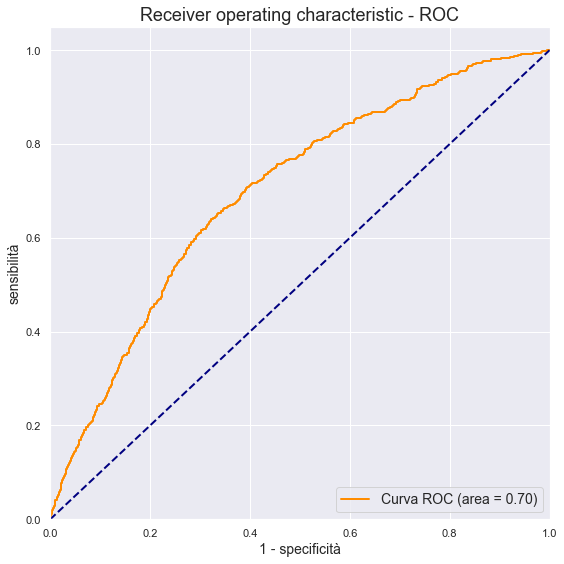

In [135]:
fontsize_for_label = 14
fontsize_for_title = 18
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(fpr, tpr, color='darkorange',
         lw=2, label='Curva ROC (area = %0.2f)' % auc_val)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('1 - specificità', fontsize = fontsize_for_label)
ax.set_ylabel('sensibilità', fontsize = fontsize_for_label)
ax.set_title('Receiver operating characteristic - ROC', fontsize = fontsize_for_title)
plt.legend(loc="lower right", fontsize = fontsize_for_label)
fig.tight_layout()

In [136]:
#salviamo la figura in memoria
fig.savefig("roc_first_model.png")
fig.savefig("roc_first_model.pdf", format = 'pdf', dpi = 1000)

In assenza di predeterminate esigenze aziendali come ad esempio la propensione al rischio dell'istituto di credito, la migliore soglia _s_ da scegliere è quella che massimizza la differenza con la bisettrice.

In [121]:
best_threshold_index = np.argmax(tpr - fpr)

#this is because sklearn uses a different formalism with respect to the reference [1]
best_threshold = thresholds[best_threshold_index] / (1 - thresholds[best_threshold_index])
sensitivity = tpr[best_threshold_index]
specificity = 1 - fpr[best_threshold_index]

print("Best choices:")
print("- Treshold s = "+str(round(best_threshold,4)))
print("- Sensitivity s = "+str(round(sensitivity,4))+" - Type I accuracy")
print("- Specificity s = "+str(round(specificity,4))+" - Type II accuracy")
print("- AUC = "+str(round(auc_val,3)))

Best choices:
- Treshold s = 1.1814
- Sensitivity s = 0.6392 - Type I accuracy
- Specificity s = 0.6784 - Type II accuracy
- AUC = 0.698


Un'altra maniera per valutare la bontà del classificatore è quella di usare la _confusion matrix_. Questa matrice, nel caso di classificazione binaria, ha una forma $2 \times 2$ e contiene quante volte abbiamo sia correttamente sia in maniera errata classificato le istanze del nostro dataset per ogni classe presente.

In [122]:
probabilities = logistic_model.predict_proba(X_test)
final_labels = np.full(shape = probabilities.shape[0], fill_value = -1, dtype=np.int8)
for i in range(probabilities.shape[0]):
    if (probabilities[i][0] / probabilities[i][1]) > best_threshold:
        final_labels[i] = 0
    else:
        final_labels[i] = 1

In [123]:
#compute confusion matrix
from sklearn.metrics import confusion_matrix

In [124]:
cm = confusion_matrix(y_test, final_labels)

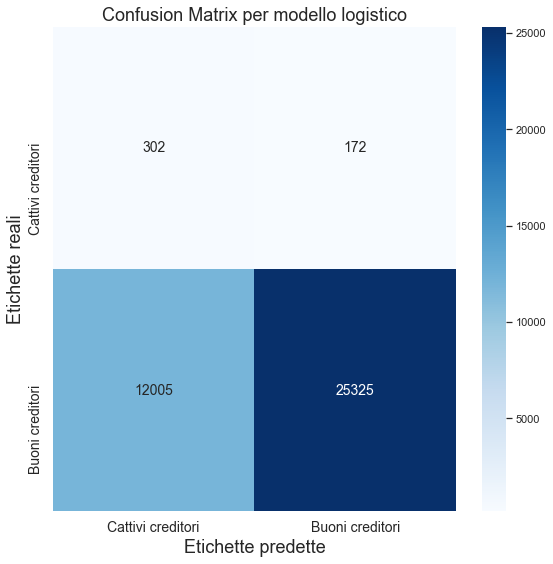

In [125]:
fontsize_for_label = 14
fontsize_for_title = 18

fig, ax = plt.subplots(1,1, figsize = (8,8))
ax = sns.heatmap(cm, annot = True, fmt="d" ,cmap = plt.cm.Blues, ax = ax, annot_kws={"fontsize":fontsize_for_label})

classes_names = ["Cattivi creditori", "Buoni creditori"]
ax.set_xticklabels(classes_names, fontsize = fontsize_for_label)
ax.set_yticklabels(classes_names, fontsize = fontsize_for_label)

ax.set_ylabel("Etichette reali", fontsize = fontsize_for_title)
ax.set_xlabel("Etichette predette", fontsize = fontsize_for_title)

ax.set_title("Confusion Matrix per modello logistico", fontsize = fontsize_for_title)
fig.tight_layout()

In [127]:
fig.savefig("confusion_matrix_first_model.png")
fig.savefig("confusion_matrix_first_model.pdf", format = 'pdf', dpi = 1000)

Un fattore considerato da \[1\] nella costruzione di un modello di credit scoring è quello di rendere il modello più _parsimonioso_ possibile, cioé utilizzare il numero minimale di variabili predittive.

In \[1\], sono presentate delle tecniche di verifica di ipotesi per giungere al modello minimale tramite _backward_, _forward_ o _stepwise_ selection. Tuttavia il pacchetto Python _sklearn_ permette di utilizzare il modello logistico con regolarizzazione di tipo L1, che riesce a ridurre a zero il coefficiente di regressione delle variabili meno predittive riuscendo quindi a fare _Feature Selection_ senza dover usare le tecniche menzionate in \[1\].

Stabilire importanza predittiva: **Permutation feature importance algorithm**

Oggigiorno l'_incredibile alta accuratezza predittiva_ dei modelli di Machine Learning ha reso il loro uso indispensabile in una vasta gamma di applicazioni. Tuttavia la loro _struttura non lineare_ li rende _poco trasparenti_ ed è difficile capire quale informazione nell'input guidi la decisione del modello \[5\]. Questo aspetto risulta rilevante in ambiti come la diagnosi medica, in cui sarebbe poco cauto affidarsi ciecamente alla decisione di un modello, o il _credit scoring_ in cui il cosiddetto "diritto alla spiegazione" obbliga gli istituti di concessione di credito a riportare una lista di ragioni per cui un finanziamento non possa essere erogato \[6\].

Per stabilire l'importanza predittiva di un modello di Machine Learning è stato proposto il **permutation feature importance algorithm** da \[7\]. L'algoritmo funziona nel seguente modo:

Input: Modello trainato $f$, matrice di dati $X$, vettore etichette $y$, funzione di perdita $L(y, f)$.

1. Stima l'errore originale del modello $e_{orig} = L(y, f(X))$, in questo caso $L$ è $1 - AUC$.
2. Per ogni feature $j = 1,…,p$:
    - Genera la matrice di dati $X_{perm}$ permutando in maniera casuale la feature $j$ nei dati $X$. Questo spezza l'associazione tra la feature $j$ e la vera etichetta $y$.
    - Stima l'errore $e_{perm}=L(y, f(X_{perm}))$ basando le predizioni sui dati permutati.
    - Calcola il *permutation feature importance* $FI_j = \frac{e_{perm}}{e_{orig}}$
    
3. Ordina le features in maniera discendente rispetto a $FI$.

Per avere una stima più accurata, ripeteremo il punto $2$ per ogni feature $j$ un numero $N=100$ di volte e plotteremo la media e la deviazione standard del campione di $N$ permutazioni.

In [128]:
#estimation of the original error
original_error = 1 - auc_val

In [129]:
N = 100
feature_importance_mean = {}
feature_importance_std = {}

for feature_j in X_test.columns:
    #generate a random permutation of feature J
    mock_data = X_test.copy()
    fi_array = np.full(shape=N, fill_value = -1.)
    for x in range(N):
        np.random.shuffle(mock_data[feature_j].values) 
        #evaluate the error
        scores = logistic_model.predict_proba(mock_data)
        fpr, tpr, thresholds = roc_curve(y_test, scores[:,0], pos_label=0)
        auc_val = auc(fpr,tpr)
        #compute the permutation error
        permutation_error = 1 - auc_val
        #store the feature importance value
        fi_array[x] = permutation_error/original_error
    feature_importance_mean[feature_j] = fi_array.mean()
    feature_importance_std[feature_j] = fi_array.std()

In [130]:
sorted_x = np.array(sorted(feature_importance_mean.items(), key=lambda kv: kv[1]))

In [131]:
negative_variable_color =  "red"#(255,0,0)
positive_variable_color =  "green"#(0,255,0)

all_coefs = logistic_model.coef_.flatten()#logistic_model.coef_.flatten()
def get_index(column_val):
    return np.where(X_train.columns.values == column_val)[0][0]

colors = [negative_variable_color if all_coefs[get_index(j)] < 0 else positive_variable_color for j in sorted_x[:,0]]

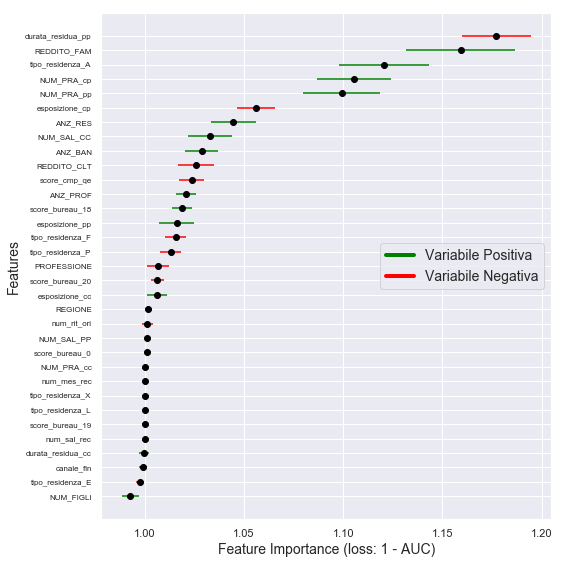

In [132]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.errorbar(y=sorted_x[:,0], x=sorted_x[:,1].astype(float), xerr=[feature_importance_std[j] for j in sorted_x[:,0]], fmt='o',color="black", ecolor=colors)

ax.set_xlabel("Feature Importance (loss: 1 - AUC)", fontsize = fontsize_for_label)
ax.set_ylabel("Features", fontsize = fontsize_for_label)
plt.tick_params(axis='y', which='major', labelsize=8)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='green', lw=4, label="Variabile Positiva"), Line2D([0], [0], color='red', lw=4, label="Variabile Negativa")]

ax.legend(handles=legend_elements, fontsize = fontsize_for_label, loc=7)
fig.tight_layout()

In [91]:
fig.savefig("feature_importance.png")
fig.savefig("feature_importance.pdf", format='pdf', dpi=1000)

E' possibile osservare che tra le variabili più importanti ci sono:

1) Durata residua al saldo dei prestiti personali in corso.

2) Se il cliente è al momento residente sotto contratto di _Affitto_.

3) Numero di prestiti personali in corso.

La variabile 1 ha una correlazione positiva con la variabile target(buon pagatore). Il modello logistico pone importanza sulla durata residua dei prestiti personali del cliente, questo aspetto non è facilmente spiegabile tramite conoscenza di dominio e per questo meriterebbe un approfondimento.

La variabile 2 ha una correlazione negativa con la variabile target che pare essere sensata visto che il cliente in affito non possiede ricchezze immobiliari per poter coprire eventuali momenti di mancanza di liquidità.

La variabile 3 ha una correlazione negativa e anche questo sembra essere sensato poiché l'accumulo di debito passato rende meno probabile la solvenza di nuovo debito.


#### Confronto con modelli di credit scoring esposti in letteratura:

Un'ulteriore valutazione della bontà del nostro modello può derivare dal confronto con modelli di credit scoring implementati in letteratura. Prenderemo spunto dal lavoro in \[3\] che utilizza Logistic Regression su tre diversi dataset e che valuta i modelli con gli indicatori AUC, sensitivity e specificity(gli stessi usati nel nostro lavoro).

La seguente tabella riporta i risultati ottenuti da West con Logistic Regression sui tre diversi dataset e dal nostro modello:

![Tabella di confronto con West, 2000](./res/tabella_di_confronto.png)

Si può osservare come i valori cambino in maniera abbastanza significativa in base al dataset usato, tuttavia il nostro modello risulta essere migliore per ognuno dei tre parametri rispetto al modello implementato da West sul dataset _England_. Ciò suggerisce che il nostro modello possa essere un buon punto di partenza per poter costruire un modello di credit scoring basato su Logistic Regression ottimale.

Riferimenti:

\[1\]: Stanghellini, E. (2009). Introduzione ai metodi statistici per il credit scoring. Springer Science & Business Media, .

\[2\]: https://en.wikipedia.org/wiki/Equal_Credit_Opportunity_Act

\[3\]: West, D. (2000). Neural network credit scoring models. Computers & Operations Research, 27, 1131-1152.

\[4\]: Abdou, H. & Pointon, J. (2011) 'Credit scoring, statistical techniques and evaluation criteria: a review of the literature ', Intelligent Systems in Accounting, Finance & Management, 18 (2-3), pp. 59-88.

\[5\]: Samech, W., Wiegand, T., & Muller, K. (2017). Explainable Artificial Intelligence: Understanding, Visualizing and Interpreting Deep Learning Models. Arxiv prePrint:arXiv:1708.08296, .

\[6\]: https://en.wikipedia.org/wiki/Right_to_explanation

\[7\]: Fisher, A., Rudin, C., & Dominici, F. (2018). All Models are Wrong but many are Useful: Variable Importance for Black-Box, Proprietary, or Misspecified Prediction Models, using Model Class Reliance. Arxiv prePrint:arXiv:1801.01489, .

\[8\]: Tibshirani, R. (1997). The LASSO method for variable selection in the Cox model. Statistics in Medicine, 16, 185-195.
